![DenseNet](https://amaarora.github.io/images/densenet.png)
## DenseNet: Densely Connected Convolutional Network

In a **DenseNet architecture**, each layer is connected to **every other layer**, which is why it is called a *Densely Connected Convolutional Network*.

For a network with **L layers**, there are:

\[
\frac{L(L+1)}{2}
\]

direct connections.

---

### Key Connectivity Idea

- Each layer receives as input the **feature maps of all preceding layers**
- Each layer’s own feature maps are passed to **all subsequent layers**
- The input to a layer is formed by **concatenation**, not summation

Formally, the input to the \(l\)-th layer is:

\[
x_l = H_l([x_0, x_1,---, x_{l-1}])
\]


---

### Why This Works

Although the idea sounds simple, it is extremely powerful.  
**DenseNets essentially connect every layer to every other layer**, enabling:

- Direct information flow between layers
- Strong feature reuse
- Efficient gradient propagation

---

### Advantages (from the Paper)

> **DenseNets have several compelling advantages:**
> - They alleviate the **vanishing-gradient problem**
> - They strengthen **feature propagation**
> - They encourage **feature reuse**
> - They substantially **reduce the number of parameters**

---

### Summary

DenseNet’s core strength lies in its **dense connectivity pattern**, where feature maps are preserved and reused throughout the network, leading to **better learning efficiency with fewer parameters**.


## Import Libraries

In [1]:
!pip install torchview

In [2]:
import torch
# all nn libraries nn.layer, convs and loss functions

import torch.nn as nn
# Display Image

from IPython.display import Image

# visualisation
import torchvision
from torchview import draw_graph

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Parameters for different DenseNet versions

![parameters](https://miro.medium.com/v2/resize:fit:1400/0*Y9CJ98fmiF6cH7w0)

In [4]:
model_parameters={}
model_parameters['densenet121'] = [6,12,24,16]
model_parameters['densenet169'] = [6,12,32,32]
model_parameters['densenet201'] = [6,12,48,32]
model_parameters['densenet264'] = [6,12,64,48]

# growth rate
k = 32
compression_factor = 0.5

## DenseLayer

## DenseNet Architecture: DenseLayer with Bottleneck

- A **DenseNet** consists of **DenseBlocks** and **Transition layers**.  
- Each **DenseBlock** contains multiple **DenseLayers**.  
- We use the **bottleneck version** of DenseLayer:



In [5]:
class DenseLayer(nn.Module):

    def __init__(self,in_channels):
        """
        First 1x1 convolution generating 4*k number of channels irrespective of the total number of input channels.
        First 3x3 convolution generating k number of channels from the 4*k number of input channels.

        Args:
        in_channels (int) : # input channels to the Dense Layer

        """
        super(DenseLayer,self).__init__()

        self.BN1 = nn.BatchNorm2d(num_features = in_channels)
        self.conv1 = nn.Conv2d( in_channels=in_channels , out_channels=4*k , kernel_size=1 , stride=1 , padding=0 , bias = False )

        self.BN2 = nn.BatchNorm2d(num_features = 4*k)
        self.conv2 = nn.Conv2d( in_channels=4*k , out_channels=k , kernel_size=3 , stride=1 , padding=1 , bias = False )

        self.relu = nn.ReLU()

    def forward(self,x):
        """
        Bottleneck DenseLayer with following operations
        (i) batchnorm -> relu -> 1x1 conv
        (ii) batchnorm -> relu -> 3x3 conv

        Concatenation of input and output tensor which is the main idea of DenseNet.

        Args:
            x (tensor) : input tensor to be passed through the dense layer

        Attributes:
            x (tensor) : output tensor

        """

        x_in = x

        # BN -> relu -> conv(1x1)
        x = self.BN1(x)
        x = self.relu(x)
        x = self.conv1(x)

        # BN -> relu -> conv(3x3)
        x = self.BN2(x)
        x = self.relu(x)
        x = self.conv2(x)

        x = torch.cat([x_in,x],1)

        return x

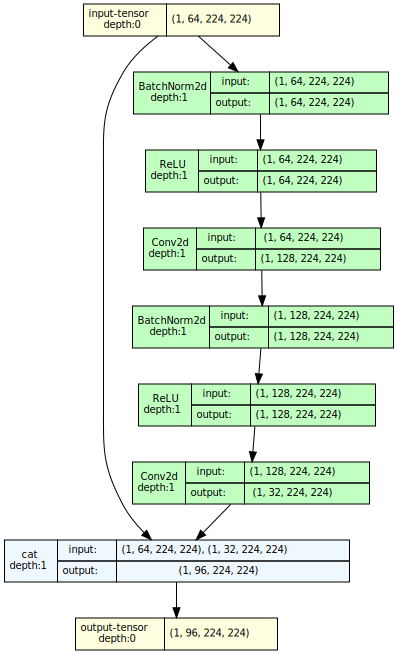

In [6]:
def test_DenseLayer():
    x = torch.randn(1,64,224,224)
    model = DenseLayer(64)
    # print(model(x).shape)
    # print(model)
    # del model
    return model


model = test_DenseLayer()

architecture = 'denselayer'
model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## DenseBlock

In [7]:
class DenseBlock(nn.Module):
    def __init__(self,layer_num,in_channels):
        """
        Looping through total number of layers in the denseblock.
        Adding k number of channels in each loop as each layer generates tensor with k channels.

        Args:
            layer_num (int) : total number of dense layers in the dense block
            in_channels (int) : input number of channels
        """

        super(DenseBlock,self).__init__()
        self.layer_num = layer_num
        self.deep_nn = nn.ModuleList()

        for num in range(self.layer_num):
            self.deep_nn.add_module(f"DenseLayer_{num}",DenseLayer(in_channels+k*num))


    def forward(self,x):
        """
        Args:
            x (tensor) : input tensor to be passed through the dense block

        Attributes:
            x (tensor) : output tensor
        """
        xin = x
        # print('xin shape',xin.shape)

        for layer in self.deep_nn:
            x = layer(x)
            # print('xout shape',x.shape)
        return x

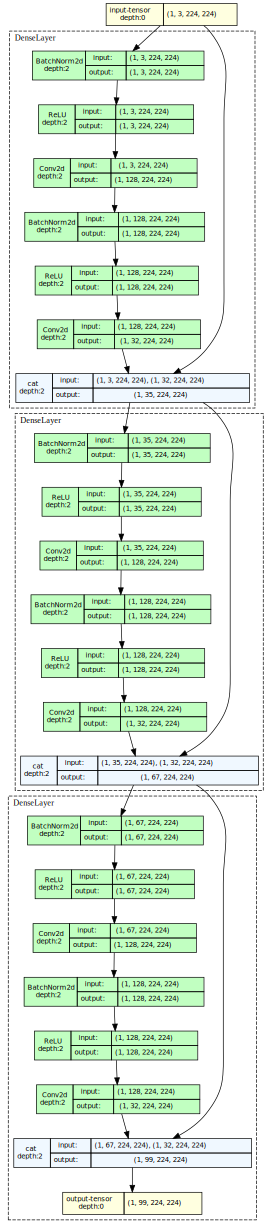

In [8]:
def test_DenseBlock():
    x = torch.randn(1,3,224,224)
    model = DenseBlock(3,3)
    # print('Denseblock Output shape : ',model(x).shape)
    # print('Model ',model)
    # del model
    return model


model = test_DenseBlock()

architecture = 'denseblock'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## Transition Layer

In [9]:
class TransitionLayer(nn.Module):
    def __init__(self,in_channels,compression_factor):
        """
        1x1 conv used to change output channels using the compression_factor (default = 0.5).
        avgpool used to downsample the feature map resolution

        Args:
            compression_factor (float) : output_channels/input_channels
            in_channels (int) : input number of channels
        """

        super(TransitionLayer,self).__init__()
        self.BN = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels = in_channels , out_channels = int(in_channels*compression_factor) ,kernel_size = 1 ,stride = 1 ,padding = 0, bias=False )
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self,x):
        """
        Args:
            x (tensor) : input tensor to be passed through the dense block

        Attributes:
            x (tensor) : output tensor
        """
        x = self.BN(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return x


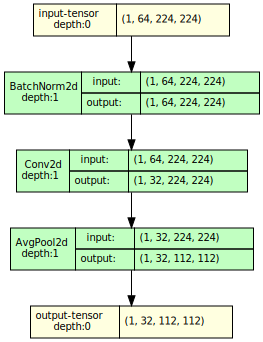

In [10]:
def test_TransitionLayer():
    x = torch.randn(1,64,224,224)
    model = TransitionLayer(64,compression_factor)
    # print('Transition Layer Output shape : ',model(x).shape)
    # print('Model : ',model)
    return model


model = test_TransitionLayer()
architecture = 'transition'
model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## Full DenseNet Architecture

In [11]:
class DenseNet(nn.Module):
    def __init__(self,densenet_variant,in_channels,num_classes=1000):

        """
        Creating an initial 7x7 convolution followed by 3 DenseBlock and 3 Transition layers. Concluding this with 4th DenseBlock, 7x7 global average pool and FC layer
        for classification
        Args:
            densenet_variant (list) : list containing the total number of layers in a dense block
            in_channels (int) : input number of channels
            num_classes (int) : Total nnumber of output classes

        """

        super(DenseNet,self).__init__()

        # 7x7 conv with s=2 and maxpool
        self.conv1 = nn.Conv2d(in_channels=in_channels ,out_channels=64 ,kernel_size=7 ,stride=2 ,padding=3 ,bias = False)
        self.BN1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


        # adding 3 DenseBlocks and 3 Transition Layers
        self.deep_nn = nn.ModuleList()
        dense_block_inchannels = 64

        for num in range(len(densenet_variant))[:-1]:

            self.deep_nn.add_module( f"DenseBlock_{num+1}" , DenseBlock( densenet_variant[num] , dense_block_inchannels ) )
            dense_block_inchannels  = int(dense_block_inchannels + k*densenet_variant[num])

            self.deep_nn.add_module( f"TransitionLayer_{num+1}" , TransitionLayer( dense_block_inchannels,compression_factor ) )
            dense_block_inchannels = int(dense_block_inchannels*compression_factor)

        # adding the 4th and final DenseBlock (separately doning this because after that no transitional layer operate  )
        self.deep_nn.add_module( f"DenseBlock_{num+2}" , DenseBlock( densenet_variant[-1] , dense_block_inchannels ) )
        dense_block_inchannels  = int(dense_block_inchannels + k*densenet_variant[-1])

        self.BN2 = nn.BatchNorm2d(num_features=dense_block_inchannels)

        # Average Pool
        self.average_pool = nn.AdaptiveAvgPool2d(1)

        # fully connected layer
        self.fc1 = nn.Linear(dense_block_inchannels, num_classes)


    def forward(self,x):
        """
        deep_nn is the module_list container which has all the dense blocks and transition blocks
        """
        x = self.relu(self.BN1(self.conv1(x)))
        x = self.maxpool(x)

        for layer in self.deep_nn:
            x = layer(x)

        x = self.relu(self.BN2(x))
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)

        # print(x.shape)
        return x

In [12]:

# x = torch.randn(1,3,224,224)
# model = DenseNet(model_parameters['densenet121'],3)

# architecture = 'denseNet'
# model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=False, expand_nested=True, show_shapes=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# # model_graph.visual_graph

In [13]:
# from torchsummary import summary
# summary(model, (3, 224, 224))

In [14]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

## Dataset preprocessing

In [15]:
def get_train_valid_loader(data_dir, batch_size, augment, random_seed, valid_size=0.1, shuffle=True):
    """Get training and validation data loaders for CIFAR-10"""

    # CIFAR-10 normalization
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )

    # Common transforms
    common_transform = [
        transforms.Resize((224, 224)),  # Resize to standard ResNet input
        transforms.ToTensor(),
        normalize
    ]

    # Training transforms with optional augmentation
    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(224, padding=4),
            transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = transforms.Compose(common_transform)

    valid_transform = transforms.Compose(common_transform)

    # Load datasets
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=train_transform
    )
    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=valid_transform
    )

    # Create train/valid split
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler
    )

    return train_loader, valid_loader

In [16]:
def get_test_loader(data_dir, batch_size, shuffle=True):
    """Get test data loader for CIFAR-10"""

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

In [17]:
# Configuration
data_dir = './data'
num_classes = 10  # CIFAR-10 has 10 classes
num_epochs = 7
batch_size = 64
learning_rate = 0.01

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
train_loader, valid_loader = get_train_valid_loader(
    data_dir=data_dir,
    batch_size=batch_size,
    augment=True,  # Enable data augmentation
    random_seed=1
)

test_loader = get_test_loader(data_dir=data_dir, batch_size=batch_size)

# Create model - FIXED: Using correct num_classes
model = DenseNet(model_parameters['densenet121'], 3, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.0001,
    momentum=0.9
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Using device: cuda


## Training

In [18]:
# Training loop
total_step = len(train_loader)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print progress every 100 steps
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

    # Epoch summary
    avg_loss = running_loss / total_step
    print(f'Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%\n')

    # Step the scheduler
    scheduler.step()

Epoch [1/7], Step [100/704], Loss: 1.7214
Epoch [1/7], Step [200/704], Loss: 1.5933
Epoch [1/7], Step [300/704], Loss: 1.5575
Epoch [1/7], Step [400/704], Loss: 1.3428
Epoch [1/7], Step [500/704], Loss: 1.2707
Epoch [1/7], Step [600/704], Loss: 0.9735
Epoch [1/7], Step [700/704], Loss: 1.1285
Epoch [1/7] - Average Loss: 1.4704
Validation Accuracy: 55.12%

Epoch [2/7], Step [100/704], Loss: 0.9100
Epoch [2/7], Step [200/704], Loss: 0.9193
Epoch [2/7], Step [300/704], Loss: 0.7199
Epoch [2/7], Step [400/704], Loss: 0.7185
Epoch [2/7], Step [500/704], Loss: 0.8575
Epoch [2/7], Step [600/704], Loss: 0.9351
Epoch [2/7], Step [700/704], Loss: 1.0506
Epoch [2/7] - Average Loss: 0.9152
Validation Accuracy: 71.54%

Epoch [3/7], Step [100/704], Loss: 0.6400
Epoch [3/7], Step [200/704], Loss: 0.4888
Epoch [3/7], Step [300/704], Loss: 0.6062
Epoch [3/7], Step [400/704], Loss: 0.6606
Epoch [3/7], Step [500/704], Loss: 0.7850
Epoch [3/7], Step [600/704], Loss: 0.6231
Epoch [3/7], Step [700/704], Los

In [19]:
# Final test evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'\nFinal Test Accuracy: {test_accuracy:.2f}%')


Final Test Accuracy: 84.55%
